# Mini Project 2

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**


###  Hypothesis Testing of Standard Assumptions Theoretical Financial Mathematics

In the theory of mathematical finance, it is common to assume the log returns of a stock/index are normally distributed.


Investigate if the log returns of stocks or indexes of your choosing are normally distributed. Some suggestions for exploration include:

    1) Test if there are period of times when the log-returns of a stock/index have evidence of normal distribution.
    
    2) Test if removing extremal return data creates a distribution with evidence of being normal.
    
    3) Create a personalized portfolio of stocks with historical log return data that is normally distributed.
    
    4) Test if the portfolio you created in the first mini-project has significant periods of time with evidence of normally distributed log returns.
    
    5) Gather x-number of historical stock data and just perform a normality test on their log return data to see if any of the stocks exhibit evidence of log returns that are normally distributed.

## Import Libraries

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
from scipy import stats
import datetime as dt
sns.set_style('darkgrid')
from fitter import Fitter, get_common_distributions, get_distributions

import yfinance as yf
import bs4 as bs
import requests
import random

# My work prior to reading the Test for Normality Notebook

## Log stock return normality

For this, I selected stocks that were large stocks with the hopes that these would be less volitile and show a normal distribution of the log returns. The stocks are:
- Coca-Cola
- Apple
- Google
- Amazon
- Direxion Daily S&P Oil
- Nvidia

I selected GUSH to add some diversity to my tests since I had picked many stocks from similar sectors. I will check normality by using the Kolmogorov–Smirnov test since it compares whether a sample of data comes from a given distribution. In this case, that distribution is the normal distribution with the mean and std from being the same as the data. This was implemented using Scipy's implementation of this. The null hypothesis is that the data comes from the given distribution. If the p-value is greater than 0.05, we fail to reject the null hypothesis, which means that it is possible that the data came from the given distribution. If p-value < 0.05, then we reject the null hypothesis.

In [41]:
# List of tickers for the stocks to be analyzed
tickers = ['KO', 'AAPL', 'GOOGL', 'AMZN', 'GUSH', 'NVDA']

# Set the date range for the past two years
start_date = dt.datetime.today()-dt.timedelta(days = 5*365)
end_date = dt.datetime.today()

# Download stock data
stock = yf.download(tickers, start = start_date, end = end_date)

[*********************100%***********************]  6 of 6 completed


In [42]:
# Create a dataframe of daily returns - log is taken to reduce computational complexity
daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns = daily_returns.dropna()

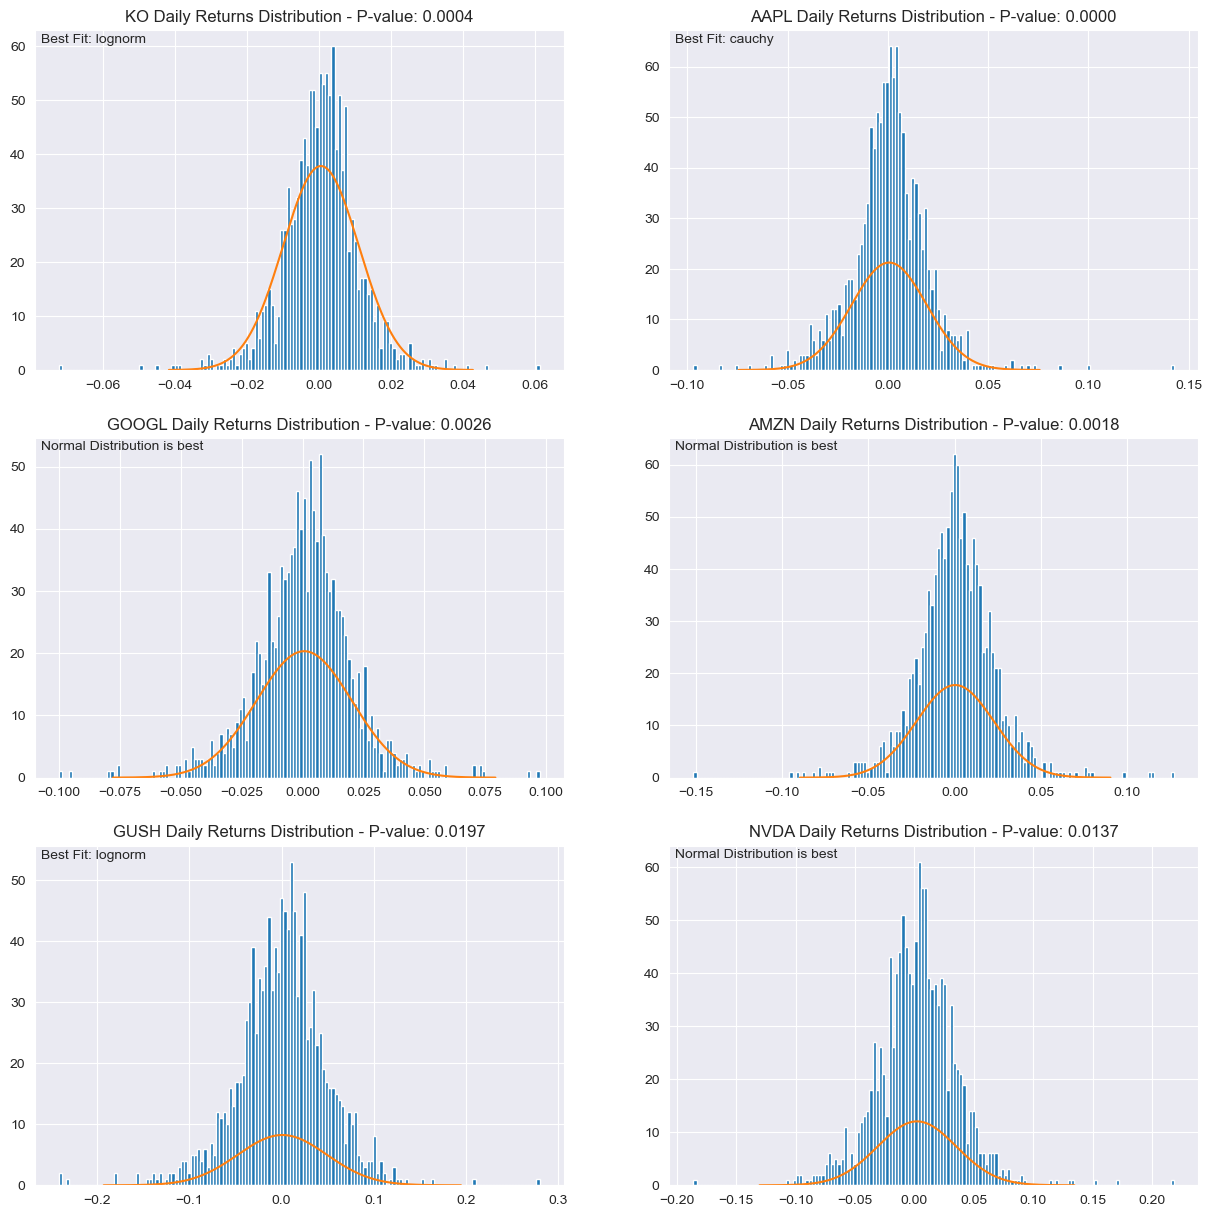

<Figure size 640x480 with 0 Axes>

In [43]:
# Plotting the daily returns distribution for each stock
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
for i in range(len(tickers)):
    # Call the daily returns for each ticker
    dr = daily_returns[tickers[i]].to_numpy()
    mu = np.mean(dr)
    sigma = np.std(dr)
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)

    # Perform the Kolmogorov-Smirnov test for normality
    # This tests if the daily returns follow a normal distribution
    ks_statistic, p_value = stats.kstest(dr, 'norm', args=(mu, sigma))
    f = Fitter(dr, distributions=get_common_distributions())
    f.fit()
    best = list(f.get_best(method='sumsquare_error').keys())[0]

    # Plot the histogram and the fitted distribution
    ax[i//2, i%2].hist(dr, bins=150)
    ax[i//2, i%2].plot(x, stats.norm.pdf(x, loc=mu, scale=sigma))
    ax[i//2, i%2].set_title(f'{tickers[i]} Daily Returns Distribution - P-value: {p_value:.4f}')
    if best == 'norm':
        ax[i//2, i%2].text(.01, .99, f'Normal Distribution is best', ha='left', va='top', transform=ax[i//2, i%2].transAxes)
    else:
        ax[i//2, i%2].text(.01, .99, f'Best Fit: {best}', ha='left', va='top', transform=ax[i//2, i%2].transAxes)
plt.show()
plt.tight_layout()

For the stocks chosen, all have a p-value less than the threshold value of 0.05, wich means that the data does not fit a normal distribution. However, using the fitter package, we can see that the normal distribution is the best fit for most of the stocks even though we reject the null hypothesis. It is likely that removing extrema will provide a better fit to the normal distribution.

## Remove Extrema

Here I am removing returns that are more than 3 standard deviations away from the mean to see if any of the log return stock data will fit the normal distribution. All other steps are the same.

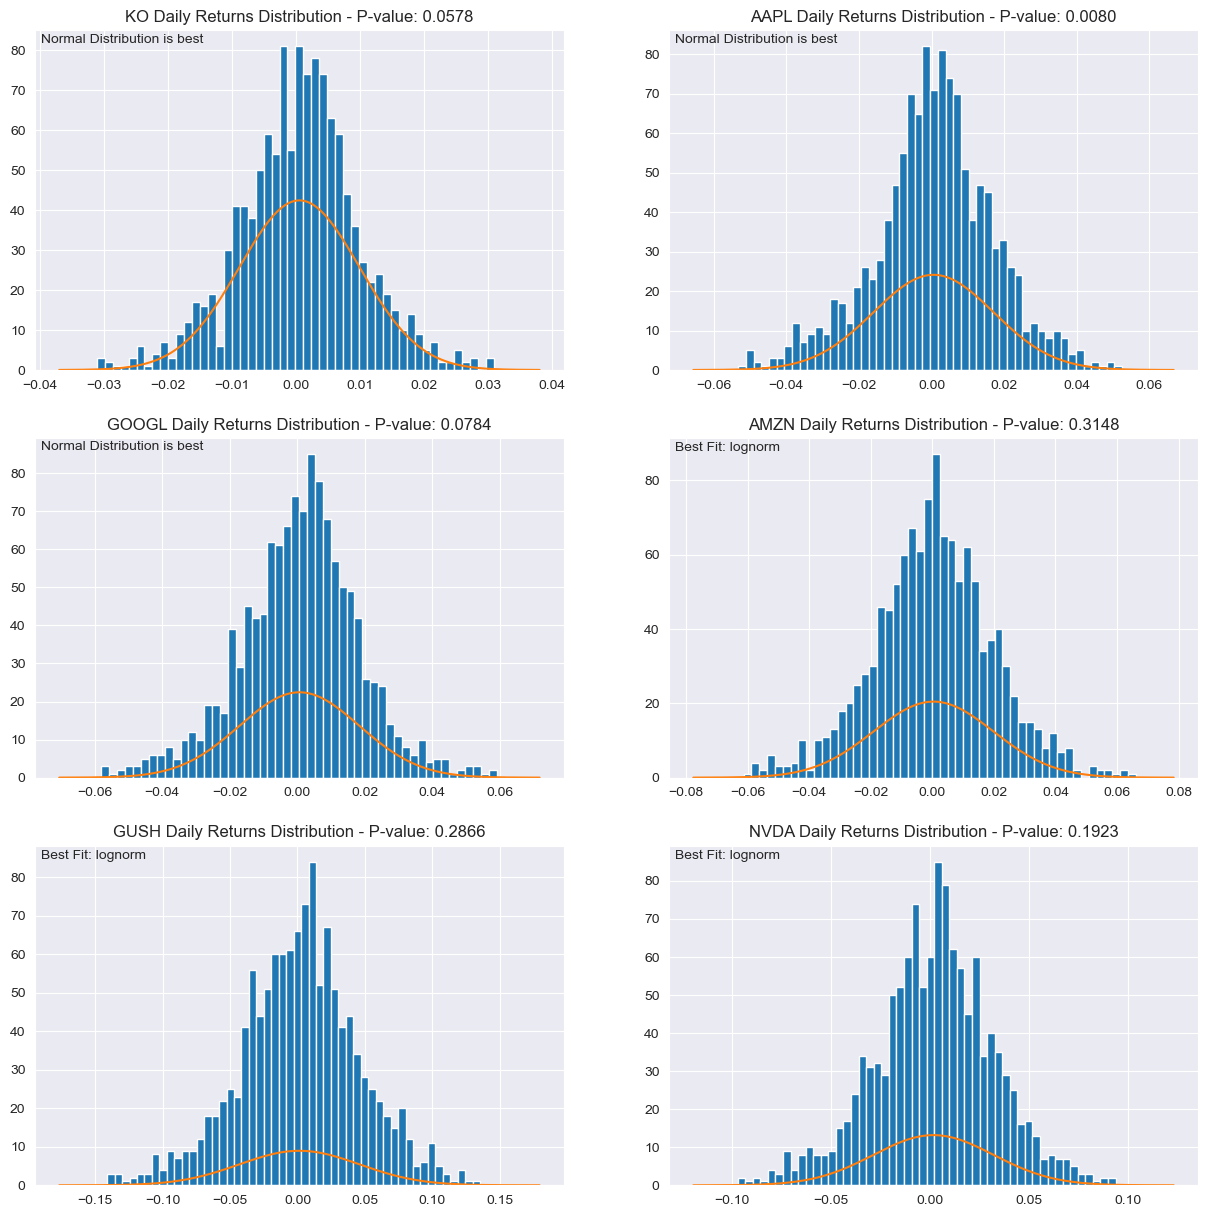

<Figure size 640x480 with 0 Axes>

In [44]:
# Remove outliers and re-evaluate the distribution
# This step is to ensure that extreme values do not skew the distribution analysis
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
for i in range(len(tickers)):
    # Call the daily returns for each ticker
    dr = daily_returns[tickers[i]].to_numpy()
    old_mu = np.mean(dr)
    old_sigma = np.std(dr)
    old_x = np.linspace(old_mu - 4*old_sigma, old_mu + 4*old_sigma, 1000)

    # Remove outliers that are more than 3 standard deviations from the mean
    min_val = old_mu - 3*old_sigma
    max_val = old_mu + 3*old_sigma
    index = np.where((dr < min_val) | (dr > max_val))
    dr = np.delete(dr, index)

    # Recalculate mean and standard deviation after removing outliers
    mu = np.mean(dr)
    sigma = np.std(dr)
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)

    # Perform the Kolmogorov-Smirnov test for normality
    # This tests if the daily returns follow a normal distribution
    ks_statistic, p_value = stats.kstest(dr, 'norm', args=(mu, sigma))
    f = Fitter(dr, distributions=get_common_distributions())
    f.fit()
    best = list(f.get_best(method='sumsquare_error').keys())[0]

    # Plot the histogram and the fitted distribution
    ax[i//2, i%2].hist(dr, bins=50)
    ax[i//2, i%2].plot(x, stats.norm.pdf(x, mu, sigma))
    #ax[i//2, i%2].plot(old_x, stats.norm.pdf(old_x, old_mu, old_sigma), color='tab:green')
    ax[i//2, i%2].set_title(f'{tickers[i]} Daily Returns Distribution - P-value: {p_value:.4f}')
    if best == 'norm':
        ax[i//2, i%2].text(.01, .99, f'Normal Distribution is best', ha='left', va='top', transform=ax[i//2, i%2].transAxes)
    else:
        ax[i//2, i%2].text(.01, .99, f'Best Fit: {best}', ha='left', va='top', transform=ax[i//2, i%2].transAxes)
plt.show()
plt.tight_layout()

We see that removing outliers allows for all but 1 of the stocks to fit the normal distribution with a p-value>0.05. 

## Personalized Portfolio of Normalized Return Data

Next, I will see how the stocks in the S&P500 index fit the normal distribution. The S&P500 is a good general benchmark for the market performance. I will load all the stocks currently on the list from Wikipedia and analyze their returns. The method for determining normality and the removing of outliers is the same as above.

In [45]:
# Get the list of S&P 500 tickers from Wikipedia
# Get the web data from the Wikipedia page
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
# Parse the HTML content using BeautifulSoup
soup = bs.BeautifulSoup(resp.text, 'lxml') 
# Find the table containing the S&P 500 tickers
table = soup.find('table', {'class': 'wikitable sortable sticky-header', 'id': 'constituents'})
tickers = []

# Extract the tickers from the table
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

# Clean the tickers
tickers = [s.replace('\n', '') for s in tickers]
tickers = [s.replace('.', '-') for s in tickers]

# Set the date range for the past two years
start_date = dt.datetime.today()-dt.timedelta(days = 5*365)
end_date = dt.datetime.today()

# Download stock data
stock = yf.download(tickers, start = start_date, end = end_date)

[*********************100%***********************]  503 of 503 completed


In [46]:
# Create a dataframe of daily returns - log is taken to reduce computational complexity
daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns = daily_returns.dropna()

In [47]:
# Save the p-values from the KS test for the S&P 500 stocks
d = {}
d_remex = {}
for i in range(len(tickers)):
    dr = daily_returns[tickers[i]].to_numpy()
    mu = np.mean(dr)
    sigma = np.std(dr)
    ks_statistic, p_value = stats.kstest(dr, 'norm', args=(mu, sigma))
    d.update({tickers[i]: p_value})

    min_val = mu - 3*sigma
    max_val = mu + 3*sigma
    index = np.where((dr < min_val) | (dr > max_val))
    dr = np.delete(dr, index)

    mu = np.mean(dr)
    sigma = np.std(dr)

    ks_statistic, p_value = stats.kstest(dr, 'norm', args=(mu, sigma))
    d_remex.update({tickers[i]: p_value})

In [48]:
# Print the results
print(f'For the S&P500, {np.sum(np.fromiter(d.values(), dtype=float) > 0.05)/5}% of stocks fit the normal distribution.')
print(f'When the extrema were removed, {np.sum(np.fromiter(d_remex.values(), dtype=float) > 0.05)/5}% of stocks fit the normal distribution.')

For the S&P500, 43.2% of stocks fit the normal distribution.
When the extrema were removed, 96.6% of stocks fit the normal distribution.


While we cannot show the results of every stock, we can look at percentages. When outliers are left in the data, only 43% of the stocks have a p-value that fails to reject the null hypothesis. However, when outliers are removed, that number jumps to over 96%.

## Mini Project 1 Normalized?

Finally, I will analyze the two positions from Mini Project 1. For a full description of that project and the idea behind the stock choices, please reference the Mini Project 1.ipynb. In short, there are 2 portfolios, 1 that has a high volatility and 1 that has a lower volatility. I will perform the same analysis as above.

In [49]:
# List of tickers for the stocks to be analyzed
tickers_high = ['WIT', 'DIDIY', 'ZTCOF', 'GRAB', 'LNVGF', 'BYDIF', 'HHUSF', 'HPHTY', 'BB', 'AWEVF']

# Randomly select 10 tickers from the S&P 500 list
rand_tickers = random.sample(tickers, 10)

# Set the date range for the past two years
start_date = dt.datetime.today()-dt.timedelta(days = 5*365)
end_date = dt.datetime.today()

# Download stock data
stock_high = yf.download(tickers_high, start = start_date, end = end_date)
stock_rand = yf.download(rand_tickers, start = start_date, end = end_date)

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


In [50]:
# Create a dataframe of daily returns - log is taken to reduce computational complexity
high_returns = np.log(stock_high['Close']/stock_high['Close'].shift(1))
high_returns = high_returns.dropna()

# Create a dataframe of daily returns - log is taken to reduce computational complexity
rand_returns = np.log(stock_rand['Close']/stock_rand['Close'].shift(1))
rand_returns = rand_returns.dropna()

In [51]:
# Save the p-values from the KS test for the high volatility stocks and random S&P 500 stocks
d_high = {}
d_rand = {}
for i in range(10):
    dr = high_returns[tickers_high[i]].to_numpy()
    mu = np.mean(dr)
    sigma = np.std(dr)
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
    ks_statistic, p_value = stats.kstest(dr, 'norm', args=(mu, sigma))
    d_high.update({tickers_high[i]: p_value})

    dr = rand_returns[rand_tickers[i]].to_numpy()
    mu = np.mean(dr)
    sigma = np.std(dr)
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
    ks_statistic, p_value = stats.kstest(dr, 'norm', args=(mu, sigma))
    d_rand.update({rand_tickers[i]: p_value})

In [52]:
# Print how many stocks fit the normal distribution with a p-value greater than 0.05 - out of 10
print(f'For the high variance portfolio, {np.sum(np.fromiter(d_high.values(), dtype=float) > 0.05)}/10 stocks fit the normal distribution with a p-value greater than 0.05.')
print(f'For the random S&P500 portfolio, {np.sum(np.fromiter(d_rand.values(), dtype=float) > 0.05)}/10 stocks fit the normal distribution with a p-value greater than 0.05.')

For the high variance portfolio, 2/10 stocks fit the normal distribution with a p-value greater than 0.05.
For the random S&P500 portfolio, 1/10 stocks fit the normal distribution with a p-value greater than 0.05.


In [53]:
# Perform the same analysis but remove outliers
dh_re = {}
dr_re = {}
for i in range(10):
    dr = high_returns[tickers_high[i]].to_numpy()
    mu = np.mean(dr)
    sigma = np.std(dr)

    min_val = mu - 3*sigma
    max_val = mu + 3*sigma
    index = np.where((dr < min_val) | (dr > max_val))
    dr = np.delete(dr, index)

    mu = np.mean(dr)
    sigma = np.std(dr)

    ks_statistic, p_value = stats.kstest(dr, 'norm', args=(mu, sigma))
    dh_re.update({tickers_high[i]: p_value})

    dr = rand_returns[rand_tickers[i]].to_numpy()
    mu = np.mean(dr)
    sigma = np.std(dr)
    
    min_val = mu - 3*sigma
    max_val = mu + 3*sigma
    index = np.where((dr < min_val) | (dr > max_val))
    dr = np.delete(dr, index)

    mu = np.mean(dr)
    sigma = np.std(dr)
    
    ks_statistic, p_value = stats.kstest(dr, 'norm', args=(mu, sigma))
    dr_re.update({rand_tickers[i]: p_value})

In [54]:
# Print the results
print(f'For the high variance portfolio, {np.sum(np.fromiter(dh_re.values(), dtype=float) > 0.05)}/10 stocks fit the normal distribution with a p-value greater than 0.05.')
print(f'For the random S&P500 portfolio, {np.sum(np.fromiter(dr_re.values(), dtype=float) > 0.05)}/10 stocks fit the normal distribution with a p-value greater than 0.05.')

For the high variance portfolio, 5/10 stocks fit the normal distribution with a p-value greater than 0.05.
For the random S&P500 portfolio, 7/10 stocks fit the normal distribution with a p-value greater than 0.05.


We see that the highly volatile portfolio has less stocks that fit the normal distribution, with only 2/10 failing to reject the null hypothesis without removing extrema. As we might expect, removing extrema did not help the highly volatile stocks as much as the stocks with a lower volatility. Removing the extrema increased the number of normally distributed stocks to 5/10 for the highly volatile, while the lower volatility stocks jumped from 1/10 stocks with extrema to 7/10 without. This is expected because a higher volatility stock would be more likely to have larger jumps in the daily return, spreading out the distribution and lowering the p-value.

# My work post reading the Test for Normality Notebook

## Log stock return normality

For this, I selected stocks that were large stocks with the hopes that these would be less volitile and show a normal distribution of the log returns. The stocks are:
- Coca-Cola
- Apple
- Google
- Amazon
- Direxion Daily S&P Oil
- Nvidia

I selected GUSH to add some diversity to my tests since I had picked many stocks from similar sectors. I will check normality by using a probablity plot and the D'Agostino and Pearson's test for normality.

In [56]:
# List of tickers for the stocks to be analyzed
tickers = ['KO', 'AAPL', 'GOOGL', 'AMZN', 'GUSH', 'NVDA']

# Set the date range for the past two years
start_date = dt.datetime.today()-dt.timedelta(days = 5*365)
end_date = dt.datetime.today()

# Download stock data
stock = yf.download(tickers, start = start_date, end = end_date)

[*********************100%***********************]  6 of 6 completed


In [57]:
# Create a dataframe of daily returns - log is taken to reduce computational complexity
daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns = daily_returns.dropna()

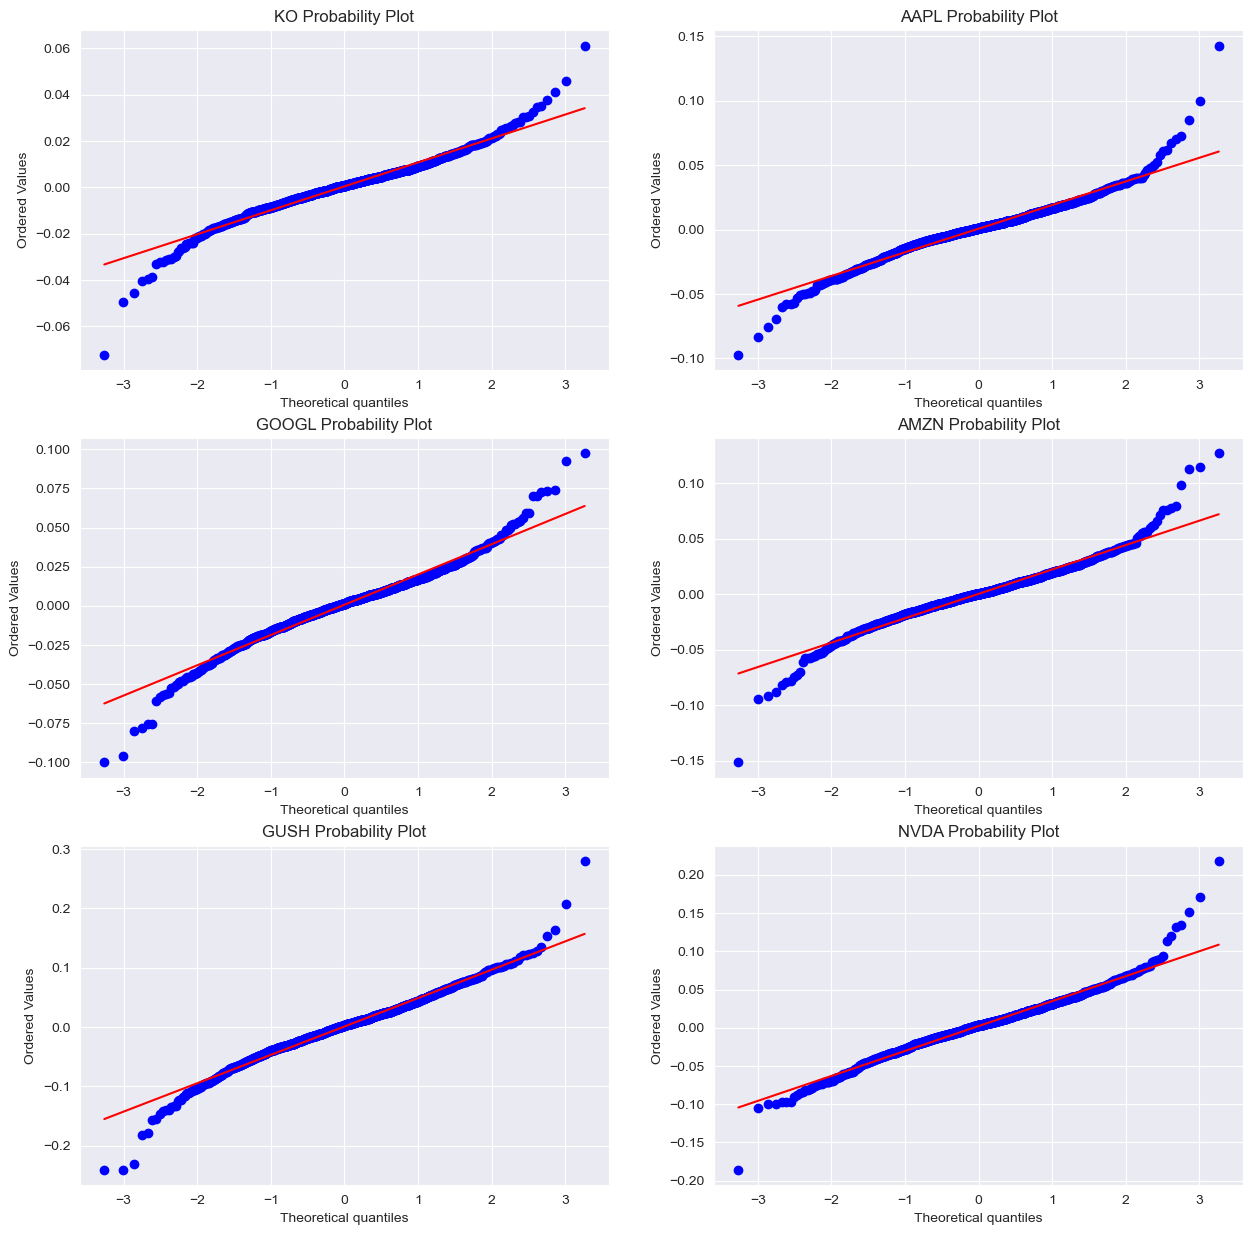

<Figure size 640x480 with 0 Axes>

In [59]:
# Plotting the daily returns distribution for each stock
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
for i in range(len(tickers)):
    # Call the daily returns for each ticker
    dr = daily_returns[tickers[i]].to_numpy()

    # Plot the probability plot of the data
    stats.probplot(dr, dist="norm", plot=ax[i//2, i%2])
    ax[i//2, i%2].set_title(f'{tickers[i]} Probability Plot')

plt.show()
plt.tight_layout()

All the probability plots seem to follow a normal distribuiton with a few outliers. However, to provide a statistical analysis of normality, I will get the p-value of each distribution.

In [63]:
for i in range(len(tickers)):
    # Call the daily returns for each ticker
    dr = daily_returns[tickers[i]].to_numpy()
    # Perform the normality test
    pval = stats.normaltest(dr)[1]
    # Print the p-value and whether the data is normally distributed
    if pval < 0.05:
        print(f'{tickers[i]} - {pval}')
        print("→ Statistically significant evidence that the data is NOT normally distributed.\n")
    else:
        print(f'{tickers[i]} - {pval}')
        print("→ No statistically significant evidence against normality.\n")

KO - 1.1207334314758928e-31
→ Statistically significant evidence that the data is NOT normally distributed.

AAPL - 1.2854541199922175e-33
→ Statistically significant evidence that the data is NOT normally distributed.

GOOGL - 1.8611147901416254e-21
→ Statistically significant evidence that the data is NOT normally distributed.

AMZN - 4.125202357843438e-30
→ Statistically significant evidence that the data is NOT normally distributed.

GUSH - 2.5336889754615876e-21
→ Statistically significant evidence that the data is NOT normally distributed.

NVDA - 3.766744235113881e-25
→ Statistically significant evidence that the data is NOT normally distributed.



This is why the analysis of the p-value was important. While the probability plots look normal enough, the p-value says otherwise.

## Remove Extrema

Here I am removing returns that are more than 3 standard deviations away from the mean to see if any of the log return stock data will fit the normal distribution. All other steps are the same.

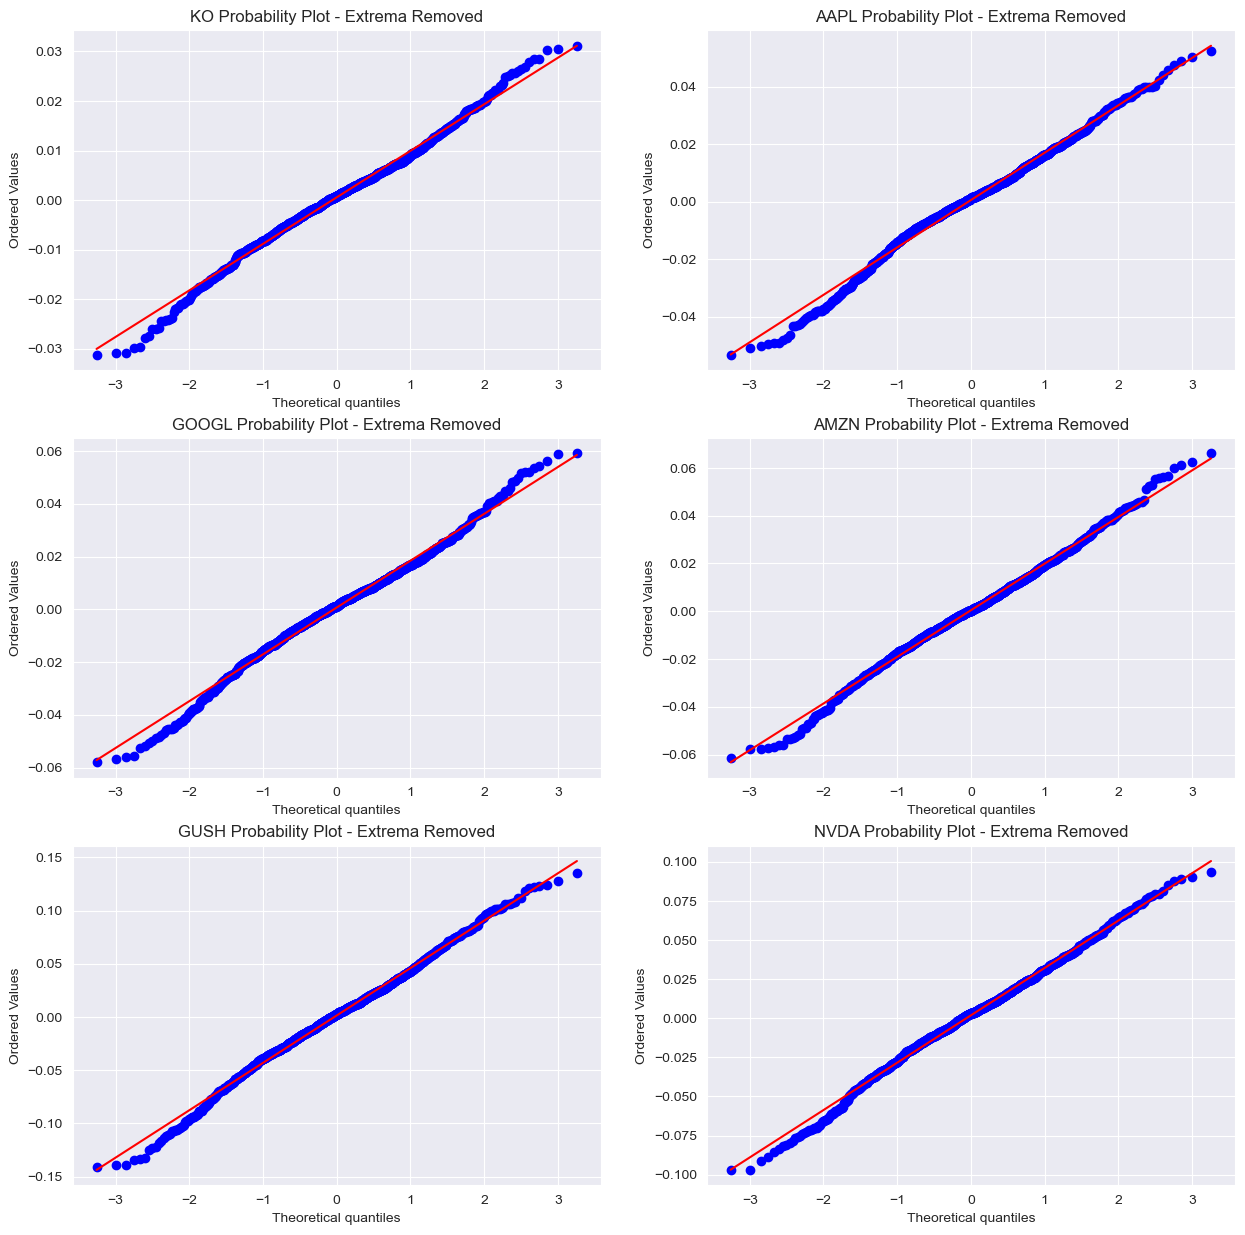

<Figure size 640x480 with 0 Axes>

In [64]:
# Remove outliers and re-evaluate the distribution
# This step is to ensure that extreme values do not skew the distribution analysis
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
for i in range(len(tickers)):
    # Call the daily returns for each ticker
    dr = daily_returns[tickers[i]].to_numpy()
    mu = np.mean(dr)
    sigma = np.std(dr)

    # Remove outliers that are more than 3 standard deviations from the mean
    min_val = mu - 3*sigma
    max_val = mu + 3*sigma
    index = np.where((dr < min_val) | (dr > max_val))
    dr = np.delete(dr, index)

    # Plot the probability plot of the data
    stats.probplot(dr, dist="norm", plot=ax[i//2, i%2])
    ax[i//2, i%2].set_title(f'{tickers[i]} Probability Plot - Extrema Removed')

plt.show()
plt.tight_layout()

These probability plots fit the normal distribution line much better than the ones without the extrema removed. To confirm that these now fit a normal distribution, we will find the p-value with the extrema removed.

In [65]:
for i in range(len(tickers)):
    # Call the daily returns for each ticker
    dr = daily_returns[tickers[i]].to_numpy()
    mu = np.mean(dr)
    sigma = np.std(dr)

    # Remove outliers that are more than 3 standard deviations from the mean
    min_val = mu - 3*sigma
    max_val = mu + 3*sigma
    index = np.where((dr < min_val) | (dr > max_val))
    dr = np.delete(dr, index)

    # Perform the normality test
    pval = stats.normaltest(dr)[1]
    # Print the p-value and whether the data is normally distributed
    if pval < 0.05:
        print(f'{tickers[i]} - {pval}')
        print("→ Statistically significant evidence that the data is NOT normally distributed.\n")
    else:
        print(f'{tickers[i]} - {pval}')
        print("→ No statistically significant evidence against normality.\n")

KO - 0.0002868593750784622
→ Statistically significant evidence that the data is NOT normally distributed.

AAPL - 0.00010082113901045845
→ Statistically significant evidence that the data is NOT normally distributed.

GOOGL - 7.79508033315517e-05
→ Statistically significant evidence that the data is NOT normally distributed.

AMZN - 0.016141551636266262
→ Statistically significant evidence that the data is NOT normally distributed.

GUSH - 0.01650400847610078
→ Statistically significant evidence that the data is NOT normally distributed.

NVDA - 0.008900009116164193
→ Statistically significant evidence that the data is NOT normally distributed.



We see that while the p-values are higher with the outliers removed, we still have evidence that these are not normally distributed.

## Personalized Portfolio of Normalized Return Data

Next, I will see how the stocks in the S&P500 index fit the normal distribution using the probability plot and D'Agostino and Pearson’s p-value. I also learned of the Yahoo's index for the S&P500, so I no longer need to scrape Wikipedia.

In [66]:
# Set the date range for the past two years
start_date = dt.datetime.today()-dt.timedelta(days = 5*365)
end_date = dt.datetime.today()

# Download stock data
stock = yf.download('^GSPC', start = start_date, end = end_date)

[*********************100%***********************]  1 of 1 completed


In [67]:
# Create a dataframe of daily returns - log is taken to reduce computational complexity
daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns = daily_returns.dropna()

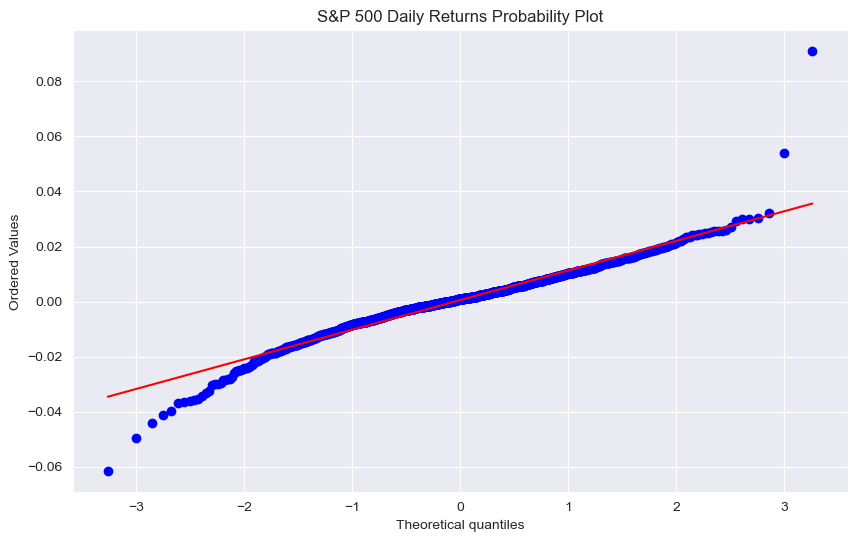

In [69]:
plt.figure(figsize=(10, 6))
# Plot the probability plot of the S&P 500 daily returns
stats.probplot(daily_returns['^GSPC'], dist="norm", plot=plt)
plt.title('S&P 500 Daily Returns Probability Plot')
plt.show()

In [ ]:
dr = daily_returns['^GSPC'].to_numpy()
mu = np.mean(dr)
sigma = np.std(dr)

# Remove outliers that are more than 3 standard deviations from the mean
min_val = mu - 3*sigma
max_val = mu + 3*sigma
index = np.where((dr < min_val) | (dr > max_val))
drnew = np.delete(dr, index)

# Perform the normality test
pval = stats.normaltest(dr)[1]
pval_new = stats.normaltest(drnew)[1]

# Print the p-value and whether the data is normally distributed
if pval < 0.05:
    print(f'S&P500 - {pval}')
    print("→ Statistically significant evidence that the data is NOT normally distributed.\n")
else:
    print(f'S&P500 - {pval}')
    print("→ No statistically significant evidence against normality.\n")

if pval_new < 0.05:
    print(f'S&P500 w.out extrema - {pval_new}')
    print("→ Statistically significant evidence that the data is NOT normally distributed.\n")
else:
    print(f'S&P500 w.out extrema - {pval_new}')
    print("→ No statistically significant evidence against normality.\n")

S&P500 - 2.317047276538423e-35
→ Statistically significant evidence that the data is NOT normally distributed.

S&P500 w.out extrema - 2.317047276538423e-35
→ Statistically significant evidence that the data is NOT normally distributed.



The S&P500 is not normally distributed with or without extrema removed.

## Mini Project 1 Normalized?

Finally, I will analyze the two positions from Mini Project 1 using the new methods above.

In [80]:
a = 0
b = 0
print("High Volatility Stocks")
for i in range(len(tickers_high)):
    dr = high_returns[tickers_high[i]].to_numpy()

    # Perform the normality test
    pval = stats.normaltest(dr)[1]
    # Print the p-value and whether the data is normally distributed
    if pval < 0.05:
        print(f'{tickers_high[i]} - {pval}')
        print("→ Statistically significant evidence that the data is NOT normally distributed.\n")
    else:
        a += 1
        print(f'{tickers_high[i]} - {pval}')
        print("→ No statistically significant evidence against normality.\n")
    
print("----------------------------------------------------------------------------------")

print("Random S&P500 Stocks")
for i in range(len(rand_tickers)):
    dr = rand_returns[rand_tickers[i]].to_numpy()
    
    # Perform the normality test
    pval = stats.normaltest(dr)[1]
    # Print the p-value and whether the data is normally distributed
    if pval < 0.05:
        print(f'{rand_tickers[i]} - {pval}')
        print("→ Statistically significant evidence that the data is NOT normally distributed.\n")
    else:
        b += 1
        print(f'{rand_tickers[i]} - {pval}')
        print("→ No statistically significant evidence against normality.\n")

High Volatility Stocks
WIT - 0.06447225500417782
→ No statistically significant evidence against normality.

DIDIY - 5.717707359976016e-20
→ Statistically significant evidence that the data is NOT normally distributed.

ZTCOF - 1.3657472583654562e-12
→ Statistically significant evidence that the data is NOT normally distributed.

GRAB - 8.972931806274743e-07
→ Statistically significant evidence that the data is NOT normally distributed.

LNVGF - 0.06393580672793456
→ No statistically significant evidence against normality.

BYDIF - 3.8018344829941854e-08
→ Statistically significant evidence that the data is NOT normally distributed.

HHUSF - 2.1345885943439224e-51
→ Statistically significant evidence that the data is NOT normally distributed.

HPHTY - 2.665362290717829e-47
→ Statistically significant evidence that the data is NOT normally distributed.

BB - 1.9187165168334678e-16
→ Statistically significant evidence that the data is NOT normally distributed.

AWEVF - 7.245259969121446e

In [81]:
# Print how many stocks fit the normal distribution with a p-value greater than 0.05 - out of 10
print(f'For the high variance portfolio, {a}/10 stocks fit the normal distribution with a p-value greater than 0.05.')
print(f'For the random S&P500 portfolio, {b}/10 stocks fit the normal distribution with a p-value greater than 0.05.')

For the high variance portfolio, 2/10 stocks fit the normal distribution with a p-value greater than 0.05.
For the random S&P500 portfolio, 0/10 stocks fit the normal distribution with a p-value greater than 0.05.


In [82]:
a = 0
b = 0
print("High Volatility Stocks")
for i in range(len(tickers_high)):
    dr = high_returns[tickers_high[i]].to_numpy()
    mu = np.mean(dr)
    sigma = np.std(dr)

    min_val = mu - 3*sigma
    max_val = mu + 3*sigma
    index = np.where((dr < min_val) | (dr > max_val))
    dr = np.delete(dr, index)

    # Perform the normality test
    pval = stats.normaltest(dr)[1]
    # Print the p-value and whether the data is normally distributed
    if pval < 0.05:
        print(f'{tickers_high[i]} - {pval}')
        print("→ Statistically significant evidence that the data is NOT normally distributed.\n")
    else:
        a += 1
        print(f'{tickers_high[i]} - {pval}')
        print("→ No statistically significant evidence against normality.\n")
    
print("----------------------------------------------------------------------------------")

print("Random S&P500 Stocks")
for i in range(len(rand_tickers)):
    dr = rand_returns[rand_tickers[i]].to_numpy()
    mu = np.mean(dr)
    sigma = np.std(dr)

    min_val = mu - 3*sigma
    max_val = mu + 3*sigma
    index = np.where((dr < min_val) | (dr > max_val))
    dr = np.delete(dr, index)
    
    # Perform the normality test
    pval = stats.normaltest(dr)[1]
    # Print the p-value and whether the data is normally distributed
    if pval < 0.05:
        print(f'{rand_tickers[i]} - {pval}')
        print("→ Statistically significant evidence that the data is NOT normally distributed.\n")
    else:
        b += 1
        print(f'{rand_tickers[i]} - {pval}')
        print("→ No statistically significant evidence against normality.\n")

High Volatility Stocks
WIT - 0.3319823795453067
→ No statistically significant evidence against normality.

DIDIY - 0.16099051891361893
→ No statistically significant evidence against normality.

ZTCOF - 7.210850352331401e-08
→ Statistically significant evidence that the data is NOT normally distributed.

GRAB - 0.009783270710588484
→ Statistically significant evidence that the data is NOT normally distributed.

LNVGF - 0.4139252657548732
→ No statistically significant evidence against normality.

BYDIF - 0.001094374664874232
→ Statistically significant evidence that the data is NOT normally distributed.

HHUSF - 3.282845136222714e-44
→ Statistically significant evidence that the data is NOT normally distributed.

HPHTY - 1.723008865834205e-60
→ Statistically significant evidence that the data is NOT normally distributed.

BB - 0.00651443090835345
→ Statistically significant evidence that the data is NOT normally distributed.

AWEVF - 0.0014328103465551692
→ Statistically significant e

In [83]:
# Print how many stocks fit the normal distribution with a p-value greater than 0.05 - out of 10
print(f'For the high variance portfolio, {a}/10 stocks fit the normal distribution with a p-value greater than 0.05.')
print(f'For the random S&P500 portfolio, {b}/10 stocks fit the normal distribution with a p-value greater than 0.05.')

For the high variance portfolio, 3/10 stocks fit the normal distribution with a p-value greater than 0.05.
For the random S&P500 portfolio, 3/10 stocks fit the normal distribution with a p-value greater than 0.05.


We see that there are significantly less normally distributed log returns with this p-value test.